In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions



D:\Users\emily\anaconda\envs\work_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Process and Train and Predict

1/1 [==============================] - 1s 1s/step


<function matplotlib.pyplot.show(close=None, block=None)>

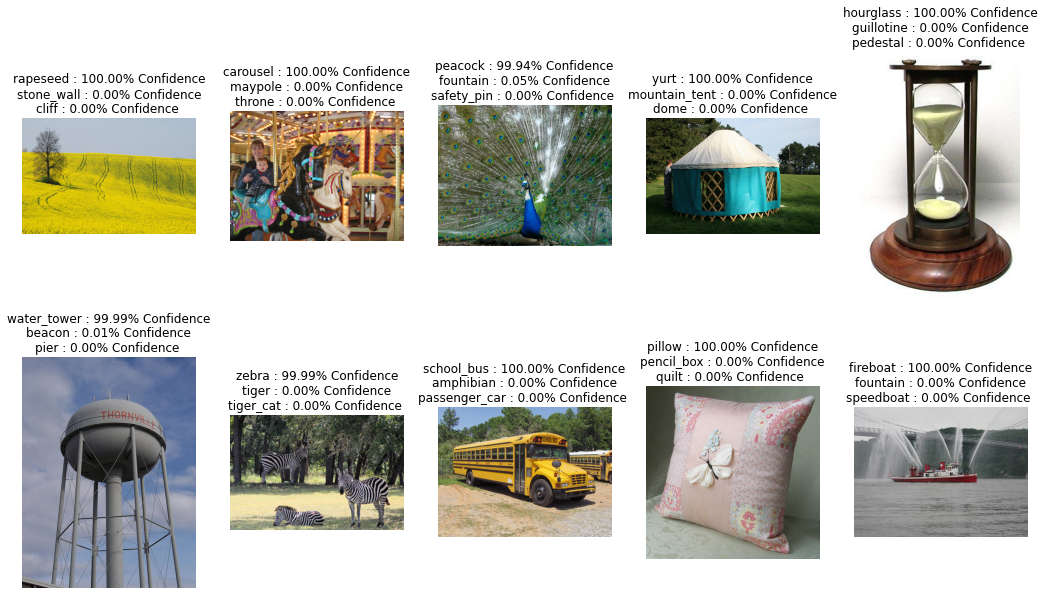

In [2]:
files = ['1.png', '10.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']
plt.figure(figsize=(18,10))
rows, cols = 2, 5

processed_img_list = []
class_label_list = []
for i in range(10):
    plt.subplot(rows, cols, i+1)
    plt.title(f'Image {files[i]}')
    plt.axis('off')
    plt.imshow(mpimg.imread(files[i]))
    
    
    ## Preprocess image
    img_path = files[i]
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    processed_img_list.append(x)
    
    
    ## Prediction of Image    
    model_MobileNetV2 = DenseNet121(weights='imagenet', include_top=True)
    preds = model_MobileNetV2.predict(x)
    
    
    #_, image_class, class_confidence = decode_predictions(preds, top=1)[0][0]
    #plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    
    
    a, b, c = decode_predictions(preds, top=3)[0]
    plt.title('{} : {:.2f}% Confidence\n{} : {:.2f}% Confidence\n{} : {:.2f}% Confidence '.format(a[1], a[2]*100,
                                                                                          b[1], b[2]*100,
                                                                                          c[1], c[2]*100))
    class_label_list.append(a[1])

plt.show

# Extract a list of all the labels in the pre-trained model

In [3]:
full_list = decode_predictions(np.expand_dims(np.arange(1000), 0), top=1000)[0]

image_class_index_list = []
#for class_iter in full_list:
#    for inner_iter in class_label_list:
#        if class_iter[1] == inner_iter:
#            image_class_index_list.append(class_iter[2])

for inner_iter in class_label_list:
    for class_iter in full_list:
        if class_iter[1] == inner_iter:
            image_class_index_list.append(class_iter[2])
            

In [4]:
image_class_index_list

[984, 476, 84, 915, 604, 900, 340, 779, 721, 554]

# Adversarial Pattern

In [5]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label, pretrained_model):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
        
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

(-0.5, 223.5, 223.5, -0.5)

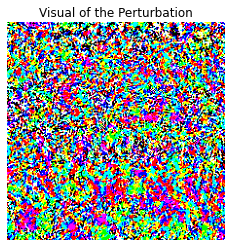

In [6]:
# Get the input label of the image.
import matplotlib.pyplot as plt
any_index = 84
label = tf.one_hot(any_index, preds.shape[-1])
label = tf.reshape(label, (1, preds.shape[-1]))

imagex = tf.cast(x, tf.float32) # <=== Changes Type
perturbations = create_adversarial_pattern(imagex, label, model_MobileNetV2)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]
plt.title("Visual of the Perturbation")
plt.axis('off')

# Test Adversarial Images

# Print Adversarial Attack for all images in subplots

for x in processed_img_list:
    epsilons = [0.01, 0.1, 0.15, 0.5]
    descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                    for eps in epsilons]
    #fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    fig, axs = plt.subplots(1, 4, figsize=(18, 15))
    count = 0
    for i, eps in enumerate(epsilons):
        adv_x = x + eps*perturbations
        adv_x = tf.clip_by_value(adv_x, -1, 1)
     
        axs[count].imshow(adv_x[0]*0.5+0.5)
        axs[count].axis('off')
        a, b, c = decode_predictions(model_MobileNetV2.predict(adv_x), top=3)[0]
        axs[count].set_title('{} \n{} : {:.2f}% Confidence\n{} : {:.2f}% Confidence\n{} : {:.2f}% Confidence '.format(descriptions[i], a[1], a[2]*100,
                                                                                          b[1], b[2]*100,
                                                                                          c[1], c[2]*100))
        count+=1
    plt.show()    


## The gradients are determined with respect to each image

984
1/1 [==============================] - 0s 31ms/step


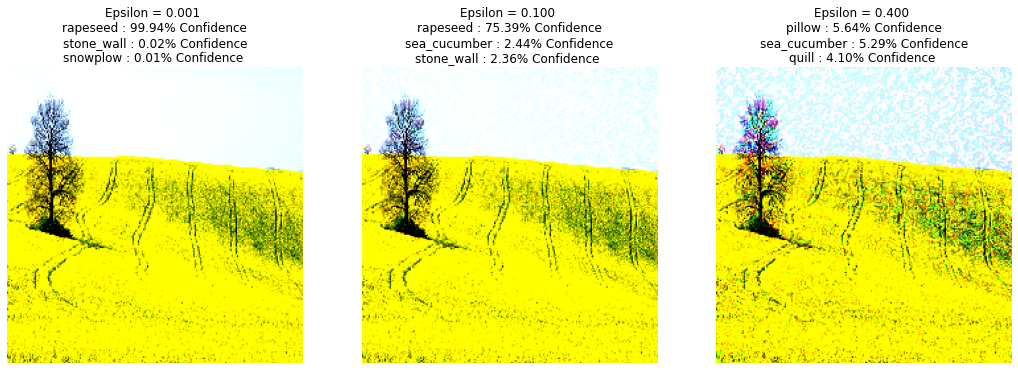

476
1/1 [==============================] - 0s 27ms/step


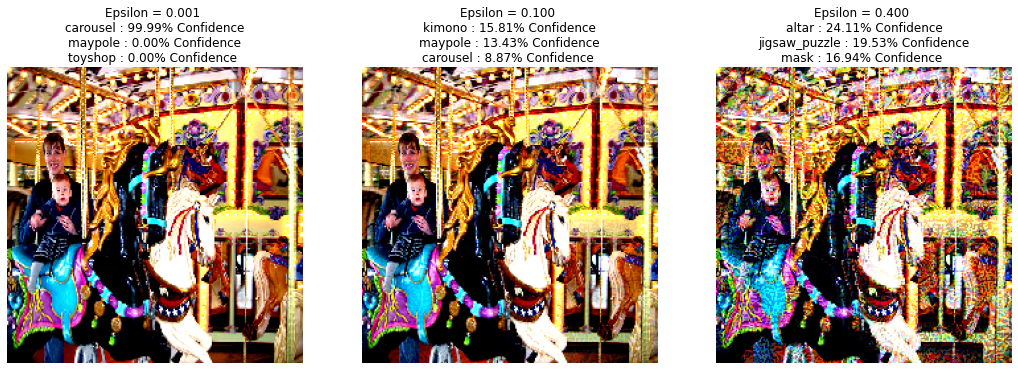

84
1/1 [==============================] - 0s 26ms/step


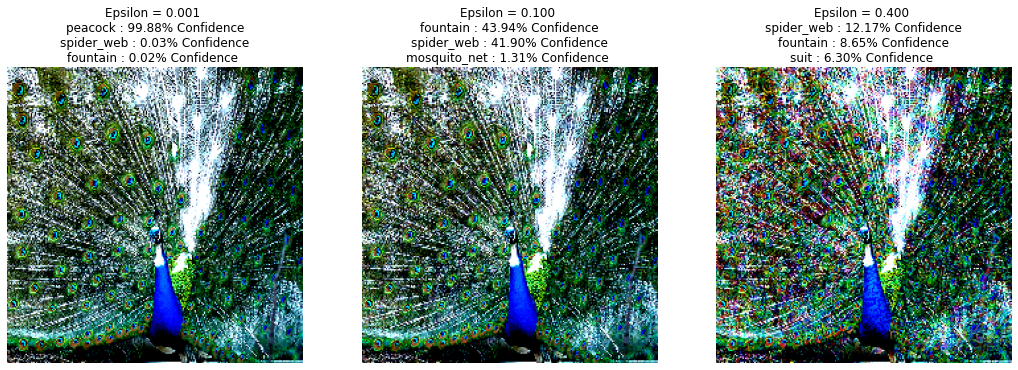

915
1/1 [==============================] - 0s 27ms/step


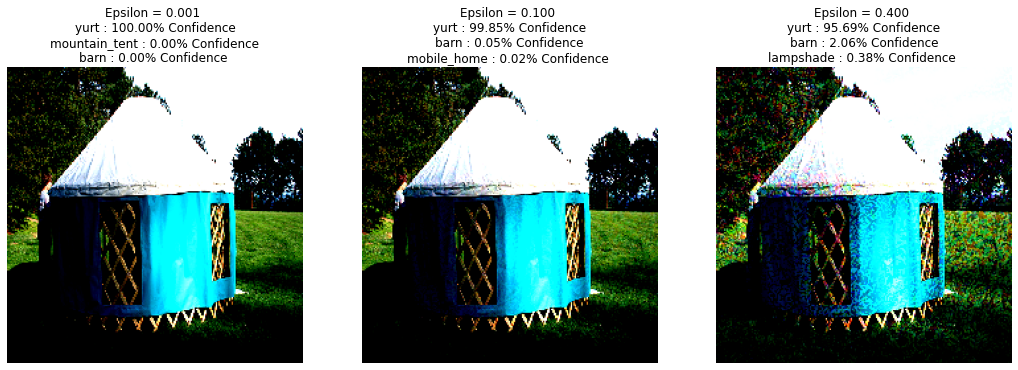

604
1/1 [==============================] - 0s 27ms/step


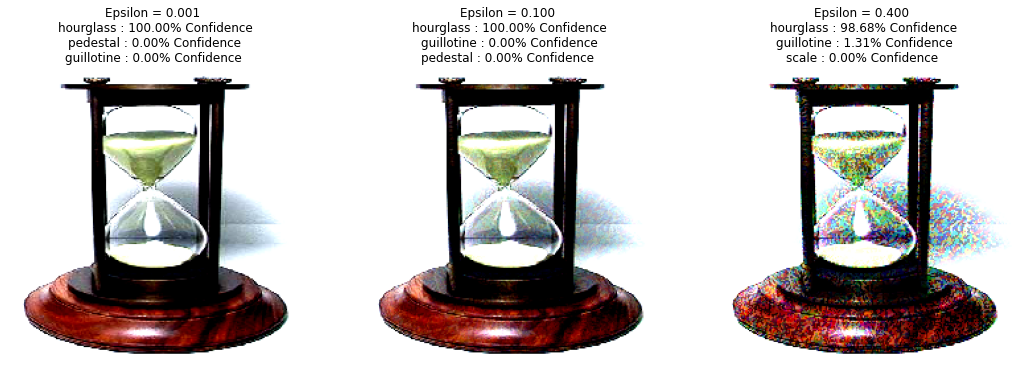

900
1/1 [==============================] - 0s 30ms/step


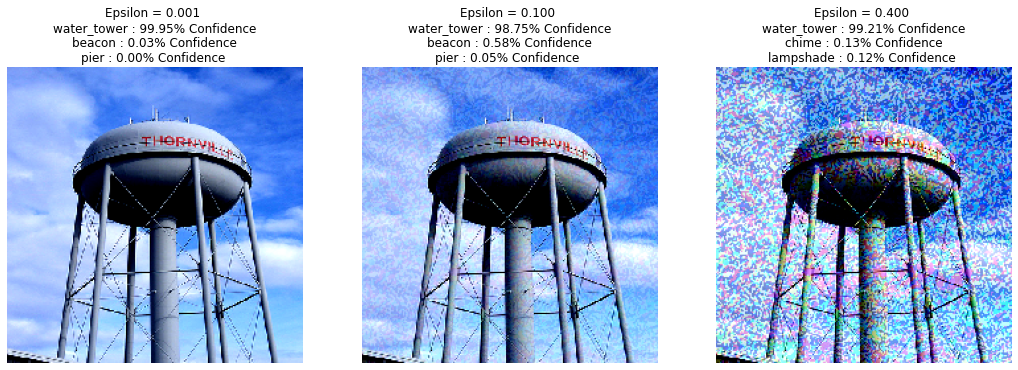

340
1/1 [==============================] - 0s 26ms/step


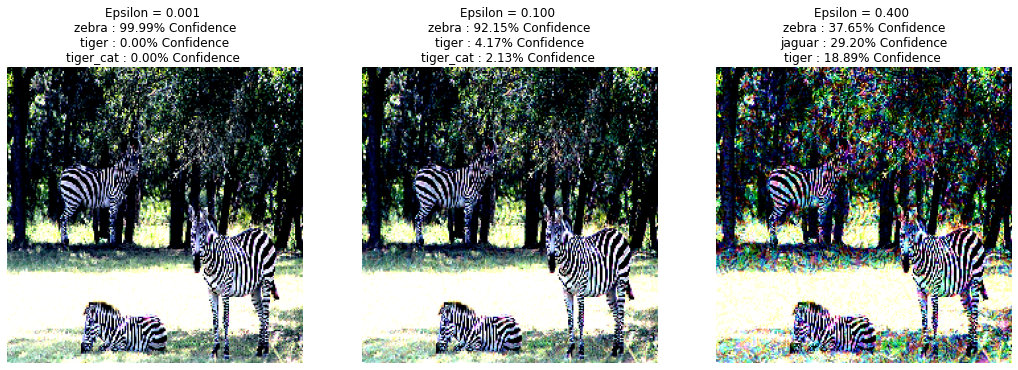

779
1/1 [==============================] - 0s 27ms/step


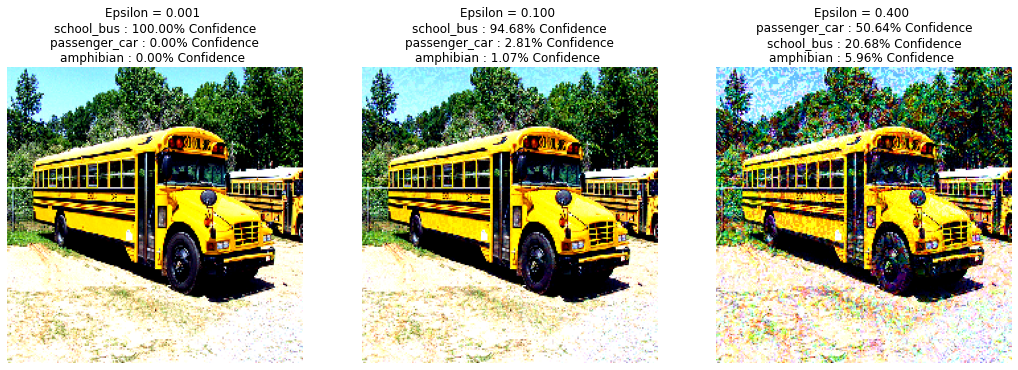

721
1/1 [==============================] - 0s 26ms/step


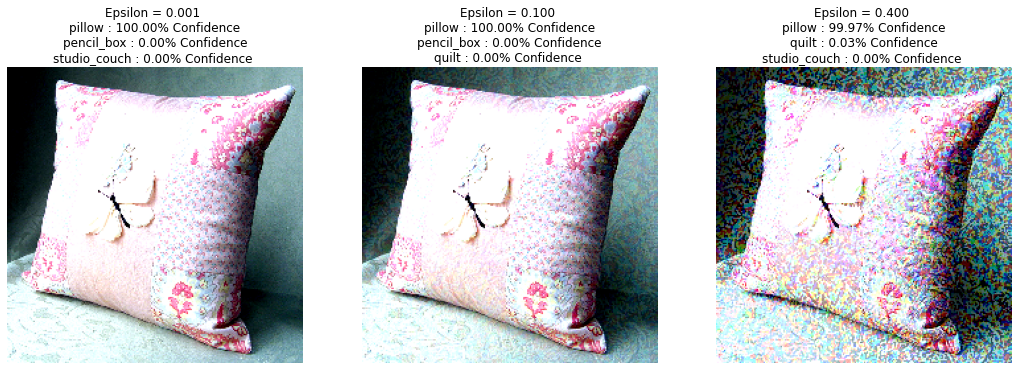

554
1/1 [==============================] - 0s 25ms/step


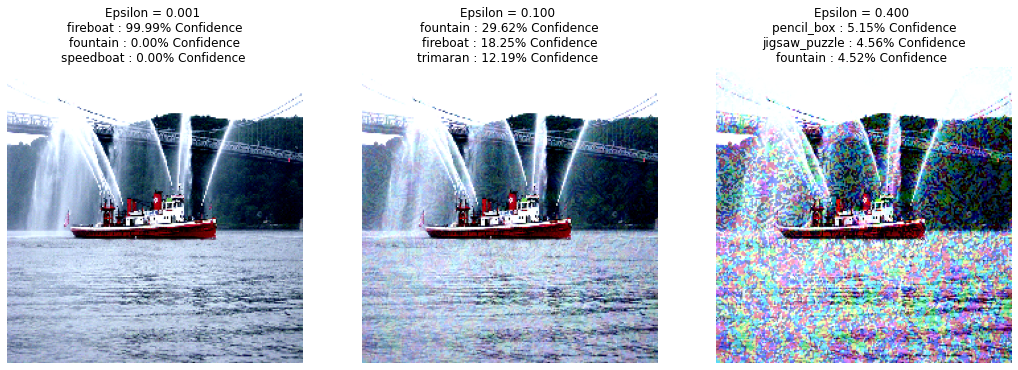

In [7]:
for index in range(0,len(processed_img_list)):
    ## Get the processed image
    x = processed_img_list[index]
    ## Get the class index of the processed image
    classindex = image_class_index_list[index]
    
    print(classindex)
    
    label = tf.one_hot(classindex, preds.shape[-1])
    label = tf.reshape(label, (1, preds.shape[-1]))
    
    ## Get the gradient with respect to each image
    imagex = tf.cast(x, tf.float32) # <=== Changes Type
    perturbations = create_adversarial_pattern(imagex, label, model_MobileNetV2)
    
    ## Iterate over various epsilon for current image
    #epsilons = [0.001, 0.01, 0.1, 0.5]
    epsilons = [0.001, 0.1, 0.4]
    descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]
    #fig, axs = plt.subplots(1, 4, figsize=(18, 15))
    fig, axs = plt.subplots(1, 3, figsize=(18, 15))
    count = 0
    for i, eps in enumerate(epsilons):
        adv_x = x + eps*perturbations
        adv_x = tf.clip_by_value(adv_x, -1, 1)
     
        axs[count].imshow(adv_x[0]*0.5+0.5)
        axs[count].axis('off')
        a, b, c = decode_predictions(model_MobileNetV2.predict(adv_x), top=3)[0]
        axs[count].set_title('{} \n{} : {:.2f}% Confidence\n{} : {:.2f}% Confidence\n{} : {:.2f}% Confidence '.format(descriptions[i], a[1], a[2]*100,
                                                                                          b[1], b[2]*100,
                                                                                          c[1], c[2]*100))
        count+=1
    plt.show()    


In [8]:
a = decode_predictions(np.expand_dims(np.arange(1000), 0), top=1000)[0]

In [9]:
a

[('n15075141', 'toilet_tissue', 999),
 ('n13133613', 'ear', 998),
 ('n13054560', 'bolete', 997),
 ('n13052670', 'hen-of-the-woods', 996),
 ('n13044778', 'earthstar', 995),
 ('n13040303', 'stinkhorn', 994),
 ('n13037406', 'gyromitra', 993),
 ('n12998815', 'agaric', 992),
 ('n12985857', 'coral_fungus', 991),
 ('n12768682', 'buckeye', 990),
 ('n12620546', 'hip', 989),
 ('n12267677', 'acorn', 988),
 ('n12144580', 'corn', 987),
 ('n12057211', "yellow_lady's_slipper", 986),
 ('n11939491', 'daisy', 985),
 ('n11879895', 'rapeseed', 984),
 ('n10565667', 'scuba_diver', 983),
 ('n10148035', 'groom', 982),
 ('n09835506', 'ballplayer', 981),
 ('n09472597', 'volcano', 980),
 ('n09468604', 'valley', 979),
 ('n09428293', 'seashore', 978),
 ('n09421951', 'sandbar', 977),
 ('n09399592', 'promontory', 976),
 ('n09332890', 'lakeside', 975),
 ('n09288635', 'geyser', 974),
 ('n09256479', 'coral_reef', 973),
 ('n09246464', 'cliff', 972),
 ('n09229709', 'bubble', 971),
 ('n09193705', 'alp', 970),
 ('n07932039

In [10]:
image_class_index_list

[984, 476, 84, 915, 604, 900, 340, 779, 721, 554]

In [11]:
class_label_list

['rapeseed',
 'carousel',
 'peacock',
 'yurt',
 'hourglass',
 'water_tower',
 'zebra',
 'school_bus',
 'pillow',
 'fireboat']